## Discovering Patterns in the Russian Housing Market for Analysis and Prediction
### 3804ICT Assignment Part I | Exponential Smoothing | Trimester 2, 2019

Joshua Russell (s5057545) | joshua.russell2@griffithuni.edu.au


Joshua Mitchell (s5055278) | joshua.mitchell4@griffithuni.edu.au


Hayden Flatley (s5088623) | hayden.flatley@griffithuni.edu.au

## 1. Introduction

### 1.1 Aim
We want to look at how the market will behave in the future so that we have the opportunity to capitalise on the market's future state. To do this we need to be able to capture patterns within the time series that take place over both long or short time periods. The moving average method only takes into account the average level from a recent history of the data and thus are only relevant for applications with little volitality and no seasonal pattern. Our data includes the day, month and year for year house transactions and spans over multiple years thus we expect to find and analyse seasonal behaviour.
We use a method known as holt winters or triple exponential smoothing that has the ability to model seasonality and trend. This algorithm not only gives us the ability to model common patterns in time series data but to make forcasts of where the data is likely to  head given our model is optimal and relevant for our data.

### 1.2 Exponential Smoothing

#### 1.2.1 Simple Exponential Smoothing

Initially we start off with single/simple exponential smoothing that exponentially decreases the influence of past points using the alpha parameter, which is representative of the weighted moving average method. Alpha is the smoothing coefficient that determines the rate of exponentially decreasing influence of historical values. Greater alpha values mean greater rates of decay. The basic equation is:
\begin{equation*}
L_t = \alpha y_{t-1} + (1 - \alpha)L_{t-1}
\end{equation*}
If we expand it becomes a summation of all previously predicted values.
\begin{equation*}
L_t = \alpha\sum_{i=1}^{t-2}(1-\alpha)^{i-1}y_{t-i} + (1-\alpha)^{t-2}L_2
\end{equation*}
From these equations we can see that they're reliant on actual data points to calculate the next point in the series. This is why single exponential smoothing gives poor forecasting results, as we hold the value constant (known as flat prediction) from the last calculated value for points further into the future. This is also why it's referred to as the level component since it offsets our values by a constant amount off from the x-axis. When using SES it's assumed that the time series has no underlying patterns as with the moving average method.

#### 1.2.2 Double expoenential smoothing

Double exponential smoothing introduces the ability to model trend with a new equation and modifies the existing level equation as follows:

\begin{equation*}
L_t = \alpha y_t + (1 - \alpha)\hat y_{t-1}
\end{equation*}
\begin{equation*}
T_t = \beta(L_t - L_{t-1}) + (1 - \beta)T_{t-1}
\end{equation*}

The level equation changes to include the value from the previous trend and level components at t - 1 as our resulting prediction the addition of both level and trend components is:
\begin{equation*}\hat y_{t+h} = L_t + h T_t\end{equation*}
The term h is a discrete value to determine the number of steps to predict ahead of our current position in time t heading in the direction determined by the trend at the end of training data points. Our second equation is an estimated of the trend or gradient with emphasis on more recent points by exponentially decaying historical points, similarly to our previous single exponential smoothing equation. Now that we have multiple equations we can also choose different variations of combining our components. This includes additive models where we assume the trend component stays constant as the level changes or a multiplicative model where trend changes with the level. We can also add dampening to reduce the influence of trend as we predict further into the future, this becomes useful we don't expect future growth to continue from the end our data. (phi is our dampening parameter).

\begin{equation*}Additive: \hat y_{t+1} = L_t + h T_t \end{equation*}
\begin{equation*}Additive Damped: \hat y_{t+1} = L_t + (\phi + \phi^2 + ... + \phi^h) T_t\end{equation*}
\begin{equation*}Multiplicative: \hat y_{t+1} = L_t T_t^h \end{equation*}
\begin{equation*}Additive Damped: \hat y_{t+1} = L_t T_t^{(\phi + \phi^2 + ... + \phi^h)}\end{equation*}

Something we must also consider is the estimation of our initial level and trend components, as they don't have past values to draw from. Our implementation simply uses the value for our first data point as the intial level and trend is the average difference between the first 3 points.

#### 1.2.3 Holt Winters (Triple Exponential Smoothing)

Finally, we must add a seasonality component to model patterns which occurs repeatedly after a certain number of seasonal periods. Its equations are as follows:

\begin{equation*}\hat Y_{t+h|t} = L_t + hT_t + S_{t+h-m(k+1)} \end{equation*}
\begin{equation*}L_t = \alpha(Y_t - S_{t-m}) + (1 - \alpha)(L_{t-1} - T_{t-1}) \end{equation*}
\begin{equation*}T_t = \beta(L_t - L_{t-1}) + (1 - \beta)T_{t-1} \end{equation*}
\begin{equation*}S_t = \gamma(Y_t - L_{t-1} - T_{t-1}) + (1 - \gamma)S_{t-m} \end{equation*}
 
The addition of the seasonality component modifies our level equation to take the difference between our known value and the seasonal value to adjust to the seasonal pattern and obtain a weighted average with the previous level and trend values. The same is done with the seasonal component itself, by taking the difference between the known value, and previous level and trend values and adding the seasonal value in the last seasonal period. Again, the trend component is unchanged. The initial seasonal values span the first entire seasonal period and are calculated by dividing or substracting  the initial level value from the first m time series values, for multiplicative and additive seasonality.

Our data with price information spans over multiple years from 8/2012 to 6/2015. From looking at the averge price per month there's no obviously consistent seasonal pattern every year as we'd expect. Therefore on top of optimising the component coefficients (alpha, beta and gamma) we endever to select a seasonal period which produces the least error for our data. In order to find the most optimal seasonal period for our data we must iterate through all of the seasonal periods from 2 - 17 months and calculate the mean square error between the raw data and our models' predictions. Alpha, beta and gamma coefficents are optimised in the library solutions and their final values used within the manual implementation.

An additive seasonal component assumes that the seasonality stays constant while multiplicative assumes that the seasonality is proportional to the local deseasonalised mean level. In our implementation we focus on using additive models for both trend and seasonality.

#### 1.3 References

Hyndman, R., Koehler, A., Ord, K. and Snyder, R. (2008). Forecasting with Exponential Smoothing. 1st ed. Springer.

Hyndman, R., & Athanasopoulos, G. (2019). Forecasting: Principles and Practice. Retrieved 6 October 2019, from https://otexts.com/fpp2/

### 2. Preprocessing

To begin with we must loud our data, import the neccessary library methods and prepare the data for the running it through our implementations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import warnings
from datetime import date
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

train_df = pd.read_csv("../Data/train.csv")
train_df = train_df[["timestamp", "price_doc"]]
warnings.filterwarnings("ignore")

In [2]:
print(f'Number of null values in price_doc: {len(train_df.loc[train_df.price_doc.isnull()])}')
print(f'Number of null values in timestamp: {len(train_df.loc[train_df.timestamp.isnull()])}')
print(f'\nTimeseries date range: {train_df.timestamp[0]} - {train_df.timestamp.iloc[-1]}')

Number of null values in price_doc: 0
Number of null values in timestamp: 0

Timeseries date range: 2011-08-20 - 2015-06-30


5850000.0

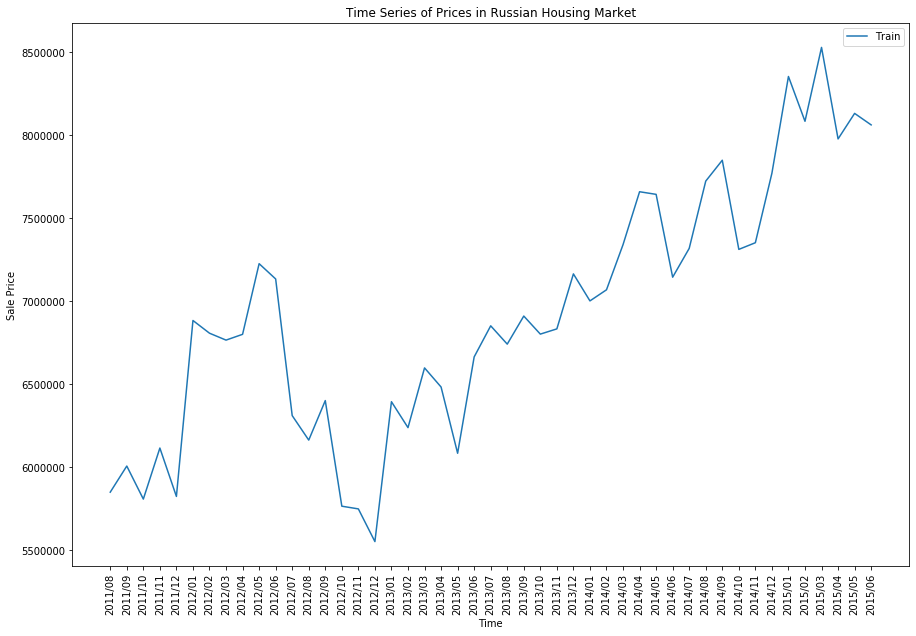

In [3]:
years = train_df['timestamp'].str[:4]
months = train_df['timestamp'].str[5:7]
days = train_df['timestamp'].str[8:10]
train_df['year'] = years
train_df['month'] = months
train_df['day'] = days

train_df["yearMonth"] = train_df['year'] + '/' + train_df['month']

train_df = train_df.groupby("yearMonth").mean().reset_index()
plt.figure(figsize=(15, 10))
sns.lineplot(train_df.yearMonth, train_df.price_doc, label='Train')
plt.xticks(rotation=90)
plt.title("Time Series of Prices in Russian Housing Market")
plt.xlabel("Time")
plt.ylabel("Sale Price")

train_df = train_df[train_df.price_doc.notnull()]

# split the data into training and test paritions to measure forecasting accuracy
split_point = int(round(46*0.8)) # split data about 80:20
train, test = train_df.iloc[:split_point], train_df.iloc[split_point-1:]


### 3. StatsModels Library Solution

This is the first library solution using StatsModels HoltWinters functions. The second library solution is located in the second forecating notebook using R. For each seasonal period from 2 to 17 months, we calculate predictions and determine the mean square and mean absolute errors with the original data. The period with the lowest error is used in our final predictions and in our comparison between methods.

seasonal period with min error: 6 - 59582587043.077156


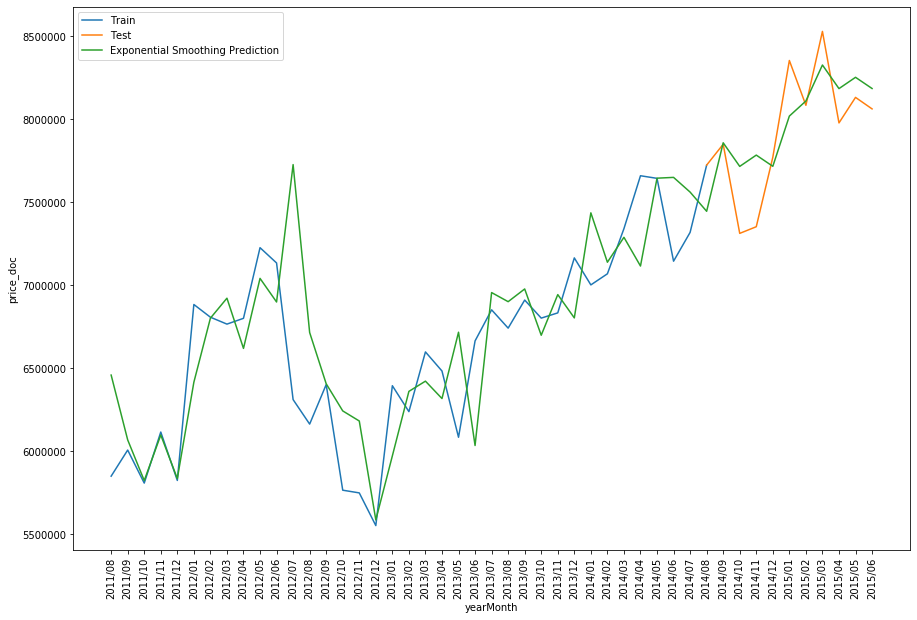

In [4]:
lib_min_error = (-1, 100000000000)
mse_lib_errors = []
mae_lib_errors = []

# iterate through seasonal periods and calculate errors
for i in range(2, 17):
    exp_model = ExponentialSmoothing(train.price_doc, trend='add', seasonal='add',  
                                         damped=False, seasonal_periods=i).fit(optimized=True, remove_bias=False)
        
    # Get predictions for start of test to the end
    pred = exp_model.predict(start=test.index[0], end=test.index[-1])#test.index[-1])

    # Calulate the error
    mse = mean_squared_error(test.price_doc, pred)
    mae = mean_absolute_error(test.price_doc, pred)
    
    # keep track of the error and each period length
    mse_lib_errors.append(mse)
    mae_lib_errors.append(mae)

    if mse < lib_min_error[1]:
        # Track min error and associated period
        lib_min_error = (i, mse)

print(f'seasonal period with min error: {lib_min_error[0]} - {lib_min_error[1]}')

exp_model = ExponentialSmoothing(train.price_doc, trend='add', seasonal='add',  
                                 damped=False, seasonal_periods=lib_min_error[0]).fit(optimized=True, remove_bias=False)

# Make model predictions from start of data to specified end.
pred = exp_model.predict(start=0, end=46)#test.index[-1])

plt.figure(figsize=(15, 10))
sns.lineplot(train.yearMonth, train.price_doc, label='Train',)
sns.lineplot(test.yearMonth, test.price_doc, label='Test')
sns.lineplot(pred.index, pred, label='Exponential Smoothing Prediction')
plt.xticks(rotation=90)

plt.legend(loc='best')

plt.show()

#### Optimising Seasonal Period

Because neither of our library implementations optimise for the most appropriate seasonal period that best fits our data. We start by calculating the MSE of the whole time series using statsmodels for each seasonal period and simply find the one which produces the minimum error. This guides in selecting the seasonal period for all of our implementations for all further analysis. Each of these error values are also stored used within our results and metrics section.S

### 4. Manual Solution

The following section contains the manual implementation of the Holt-Winters exponential smoothing functions.

In [5]:
class Exponential_Smoothing:
    
    """
        An implementation of the holt-winters/triple expoentioal smoothing method for 
        modelling time series data and making forecasts. 
        
        Parameters
            data - time series data to model

            m - the seasonal period of the data

            trend (add | mul) - default: add
                selects the type of trend component to use in the model

            seasonality (add | mul) - default: add
                selects the type of seasonality component used in the model
            
            coefficients - default: alpha = 0.7034679, beta = 0.0137731, gamma = 0.1358152
                optional parameter to specify the model's alpha (level), beta (trend) 
                and gamma (seasons) coefficients
        
        Returns
            fitted - Fitted time series data predictions from combining level, trends and seasons components.
            levels - The final level component data including forecasted values.
            trends - The final trends component data including forecasted values.
            seasons - The final seasons component data including forecasted values.
    """
    
    def __init__(self, data, m=None, trend='add', seasonality='add', coefficients=None):
        """
            Initialises the classes variables and flags that are used across functions 
            which contains informations about the models coefficients and types of trend 
            and seasonality components.
        """
        
        self.data = data
        self.len_d = len(data)
        if seasonality in ['mul', 'add', None]:
            self.seasonality = seasonality
        
        if trend in ['mul', 'add', None]:
            self.trend = trend

        self.m = m

        if coefficients == None:
            self.alpha = 0.334679
            self.beta = 0.0137731
            self.gamma = 0.7358153
        else:
            self.alpha = coefficients[0]
            self.beta = coefficients[1]
            self.gamma = coefficients[2]
        
        self.init_components()
        
    def init_components(self):
        """
             Calculates the starting values of level, trend and seasonal components 
             depending on their types.
        """
        # Determine initial level by calculating the average of all values at first seasonal index
        self.l0 = self.data[np.arange(self.len_d) % self.m == 0].mean()
        
        # get first and second seasonal periods
        lead, lag = list(self.data[self.m:(2*self.m)]), list(self.data[:self.m])

        # Determine initial trend
        if self.trend == 'mul':
            self.t0 = np.exp((np.log(lead.mean()) - np.log(lag.mean())) / self.m)
        elif self.trend == 'add':
            # Calculate the mean of the difference between 1st and 2nd seasonal periods / seasonal length 'm'
            self.t0 = np.mean([x/self.m for x in [lead[i] - lag[i] for i in range(self.m)]])

        # Determine initial seasonality values
        if self.seasonality == 'mul':
            # divide each value in first seasonal period by the initial level
            self.s0 = list(self.data[:self.m] / self.l0)
        elif self.seasonality == 'add':
            # Calculate difference of each value in first seasonal period with the initial level
            self.s0 = list(self.data[:self.m] - self.l0)
        
        #print(f'l0: {self.l0}\nt0: {self.t0}\ns0: {self.s0}')
        
    def predict(self, start=None, end=None):
        """
            Preprocesses the start and end indices to find how far into the future a forecast is 
            to be made where end is greater than the training data or the range for applying 
            smoothing to the existing data.
            
            Params:
                start - the index from which to start predictions
                end - the final index to predict/forecast.
                
            Return:
                fitted, levels, trends and seasons lists from _predict
        """
        
        if start == None:
            start = 0
        if end == None:
            end = self.len_d + 1
        beyond_data = end - self.len_d

        if beyond_data > 0:
            return self._predict(h=beyond_data, start=start, end=end+1)

        else:
            return self._predict(h=0, start=start, end=end)
    
    def _predict(self, h, start, end):
        
        """
            Internal functions which calculates predictions/forecasts given a start, and end and 
            forcast variable h.
            
            Params:
                start - index from where to start predictions
                
                end - the final index where we stop predictions. End will not go beyond the last 
                index in the training data.
                
                h - is the forecasting variable that determines how far into the future to make 
                predictions from the end of the training data.
                
            Return:
                fitted - the combined components for predictions (values that are computed from observations ) 
                        with the forecast values (without observations) appended.
                levels - The level time series component
                trends - The trend time series component
                seasons - The seasonality time series component
        """
        
        levels = [self.l0]
        trends = [self.t0]
        seasons = np.zeros((self.len_d + h + self.m + 1, ))
        seasons[:self.m] = self.s0
        
        #print(f'start: {start}')
            
        # iterate though each consecutive value in the time series, skiping the initial values
        for t in range(1, self.len_d):
            
            # Calculate level @ t
            levels.append(self.alpha*(self.data[t-1] - seasons[t-self.m]) + 
                          (1 - self.alpha)*(levels[t-1] - trends[t-1]))
            
            # Calculate trend @ t
            if self.trend == 'mul':
                pass
            elif self.trend == 'add':
                trends.append(self.beta*(levels[t] - levels[t-1]) + ((1 - self.beta)*trends[t-1]))

            # Calculate seasonality @ t
            if self.seasonality == 'mul':
                pass
            elif self.seasonality == 'add':
                # update the value at the same seasonal index in the next seasonal period
                seasons[t + self.m - 1] = self.gamma*(self.data[t-1] - levels[t-1] - trends[t-1]) 
                + (1 - self.gamma)*seasons[t-1]
        
        # Calculate prediction (y hat) by combining components
        last_level = levels[-1]
        last_trend = trends[-1]
        
        # Apply constant level for forecasting and use that value to calculate trend with 
        # our holt-winters trend equation
        for i in range(h ):
            levels.append(last_level)
            trends.append(last_trend * i)

        trend_line = []
            
        # Combine trend with either multiplicative or additive methods
        if self.trend == 'mul':
            pass
        elif self.trend == 'add':
            trend_line = np.add(trends, levels)
        
        # Continue seasonality for end to end + h
        seasons[self.len_d + self.m -1:] = [seasons[(self.len_d - 1) + j % self.m] for j in range(h + 2)]
        
        # Join trend and seasonality components
        fitted = trend_line + seasons[:-self.m -1]    
        
        return fitted, levels, trends, seasons


#print(f'results:\n{results}')

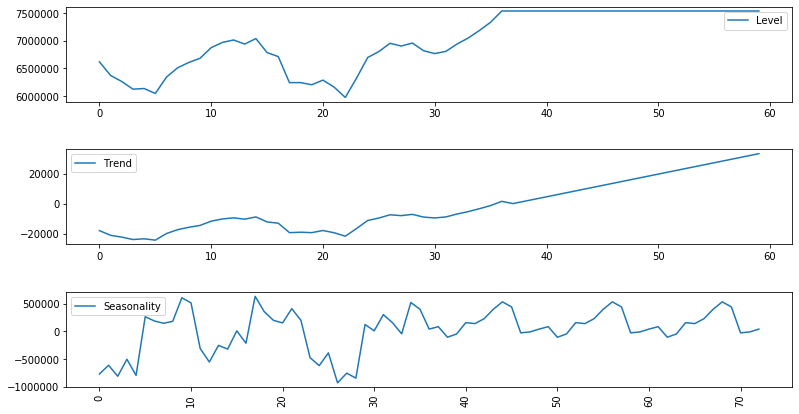

In [6]:
exp_sm  = Exponential_Smoothing(train.price_doc, m=12)
results, levels, trends, seasons = exp_sm.predict(start=0, end=60)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(13,7))
plt.subplots_adjust(hspace=0.5)

sns.lineplot(x=range(len(levels)), y=levels, label='Level', ax=ax1)
sns.lineplot(x=range(len(trends)), y=trends, label='Trend', ax=ax2)
sns.lineplot(x=range(len(seasons)), y=seasons, label='Seasonality', ax=ax3)
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

When compute our fitted values we combine each of the exponential smoothing components in order to model increasing complex characteristics of our time series. In our manual implementation we returned both the fitted values and the individual components. Decomposing our model allows us to see how each one contributes to accuracy of our fitted model. We can see that the level component is equivalent to a weighted moving average, placing the model at roughly the same height as the observations. Here the trend only has a very small influence on our model compared to level and seasonality, slightly nudging it in a general direction. Seasonality on the otherhand has a strong influence on our models predictions. By looking our models components we can see what information lies within our data. A strong seasonal pattern indicates that russian housing prices are therefore strongly influenced by the time of year that they're being sold in. Ranging from a minimum of -1, 000, 000 rubles near the start of the year to 500, 000 toward the end in fluctuations. Because our model has such a minsquel trend component we can see that the housing market is relatively stable over the period of our data. We notice that there are also oscillating cycles within the trend spanning periods of around 2 years.

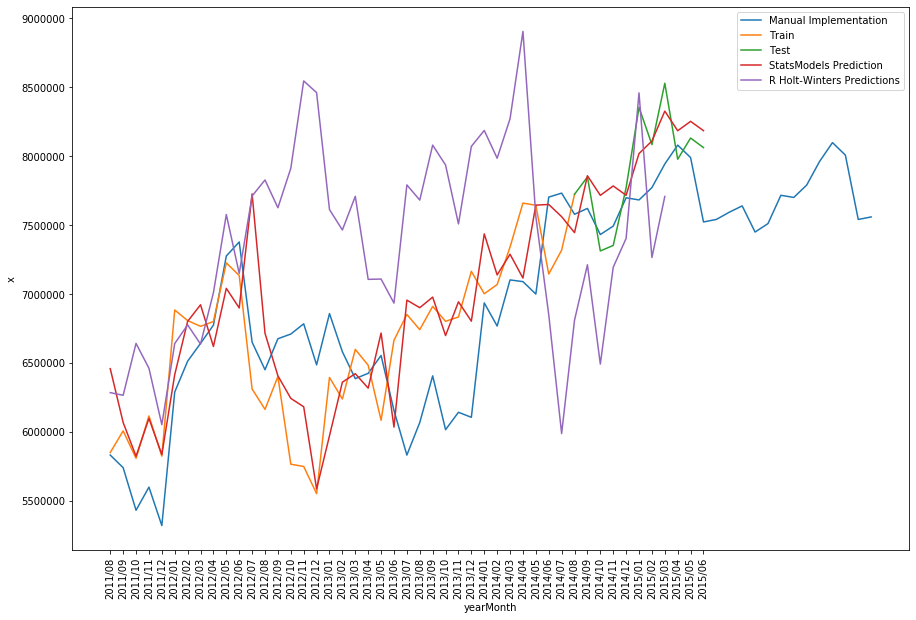

In [7]:
r_results = pd.read_csv("./R_Forecasting_Results.csv")["x"]

plt.figure(figsize=(15, 10))
sns.lineplot(x=range(len(results)), y=results, label='Manual Implementation')
sns.lineplot(train.yearMonth, train.price_doc, label='Train',)
sns.lineplot(test.yearMonth, test.price_doc, label='Test')
sns.lineplot(pred.index, pred, label='StatsModels Prediction')
sns.lineplot(x=range(len(r_results)), y=r_results, label="R Holt-Winters Predictions")
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

Now we examine the predictions and forecasts of each of our implementation alongside training and test sets. We're looking for the model that best fits the time series across both the training and test sets most closely. In our results we formalise the comparison between the implementations by using the MSE and MAE errors. For now we make visual comparison from our own judgement. Firstly, the clearly worst performing implementation is R's Holt-Winters library. After it reaches the end of the first seasonal period it shows very inconsistent predictions which seem very sporadic and don't follow the sales  price time series data. In contrast the statsmodels and manual implementation show far better predictive performance by closely fitting the sales price consistently. This provides proof that the Holt Winters exponential smoothing model is sufficiently sophisticated and can effectively be applied to the Russian houseing market domain. 

### 5. Results and Metrics

#### Comparison with Error Metrics
Now we provide results and compare the Statsmodels and R Holt Winters library solutions with our manual implementation on the Russian Housing Market Dataset. To compare methods we average predictions and then take the mean absolute error and mean square error.

#### Mean Square Error
The mean square error is the averaged squared difference between the observations $y_t$ and our predictions/forecasts $\hat y_t$ for our all of our time series data $n$.

$$MSE = \frac{1}{n} \sum\limits_{i=1}^{n} \left( y_t - \hat y_t \right) ^2$$

As MSE becomes larger, the difference between predicted/forecasted values and observations change at the rate of the errors square root prior to averaging. Larger differences tell us that our model is performing poorly at predicting/forecasting values. The smaller our error, the better our model is performing where zero gives a perfect prediction.

#### Mean Absolute Error

The mean absolute error the absolute value of the difference between our observations $y_t$ and the model's predictions/forecasts $\hat y_t$ for all observations $n$:
   
$$MAE = \frac{1}{n} \sum\limits_{i=1}^{n} | y_t - \hat y_t |$$

As MSE becomes larger, the difference between predicted/forecasted values and observations change at the same rate as our error prior to averaging. Larger differences tell us that our model is performing poorly at predicting/forecasting values. The smaller our error, the better our model is performing where zero gives a perfect prediction.

Since MSE squares the errors, it exacerbates larger differences more so than smaller differences. MAE does not have this characteristic and therefore is able to handle outliers better than MSE. 

#### Error Comparison

Below we compare the implementations by calculating the MSE and MAE errors, again for seasonal periods from 2 to 17 months but with our manual implementation. Error for our R Holt-Winter library implementation are exported to a csv from our R Forecasting notebook and read into a dataframe so that we plot all implementations together in a single graph. 

Both statsmodels and our manual implementation produce reasonable results. Generally our manual implementation consistently has a lower error across all seasonal periods while statsmodels produces the mimimum error on all seasonal periods from 2 to 8 and 12 months. In all of our implementations where're using both and additive trend and seasonal components without dampening equations. Therefore the difference between the implementations may come down how they calculate their inital component values and the slight variations in how each component is calculated. Our manual implementation uses the original holt-winters equations and thus the library solutions may use other variations that have come about since.

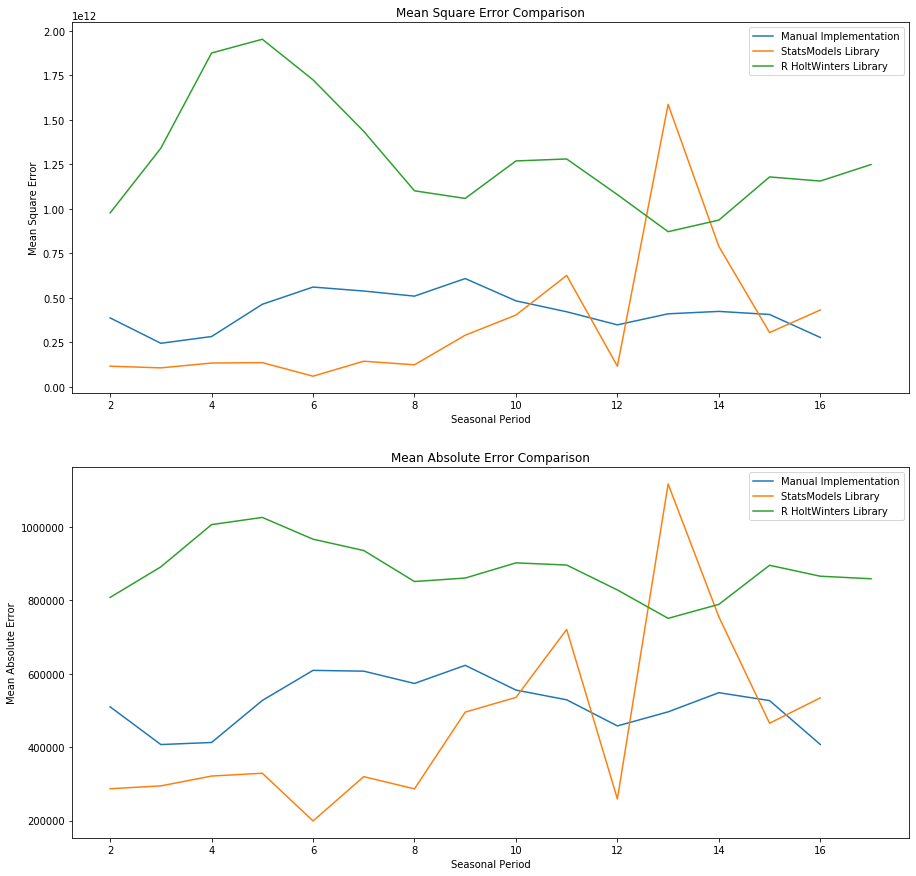

In [8]:
# plot the errors of lib and manual seasonal periods 9 to 16
mse_manual_errors = []
mae_manual_errors = []

r_mse_result = pd.read_csv("./R_Forecasting_MSE.csv")['mse']
r_mae_result = pd.read_csv("./R_Forecasting_MAE.csv")['mae']

for i in range(2, 17):
    manual_exp_sm  = Exponential_Smoothing(train.price_doc, m=i)
    
    # Get predictions for start of test to the end
    results, levels, trends, seasons = manual_exp_sm.predict(start=0, end=train_df.index[-1])

    mse_manual_error = mean_squared_error(train_df.price_doc[1:], results)
    mae_manual_error = mean_absolute_error(train_df.price_doc[1:], results)
    

    mse_manual_errors.append((i, mse_manual_error))
    mae_manual_errors.append((i, mae_manual_error))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))

# Mean Square error
sns.lineplot(x=[x[0] for x in mse_manual_errors], y=[x[1] for x in mse_manual_errors], label='Manual Implementation', ax=ax1)
sns.lineplot(x=range(2, len(mse_lib_errors) + 2), y=[x for x in mse_lib_errors], label='StatsModels Library', ax=ax1)
sns.lineplot(x=range(2, len(r_mse_result) + 2), y=[x for x in r_mse_result], label="R HoltWinters Library", ax=ax1)
ax1.legend(loc='best')
ax1.set_title("Mean Square Error Comparison")
ax1.set_ylabel("Mean Square Error")
ax1.set_xlabel("Seasonal Period")

# Mean absolute error
sns.lineplot(x=[x[0] for x in mae_manual_errors], y=[x[1] for x in mae_manual_errors], label='Manual Implementation', ax=ax2)
sns.lineplot(x=range(2, len(mae_lib_errors) + 2), y=[x for x in mae_lib_errors], label='StatsModels Library', ax=ax2)
sns.lineplot(x=range(2, len(r_mae_result) + 2), y=[x for x in r_mae_result], label="R HoltWinters Library", ax=ax2)
ax2.legend(loc='best')
ax2.set_title("Mean Absolute Error Comparison")
ax2.set_ylabel("Mean Absolute Error")
ax2.set_xlabel("Seasonal Period")
plt.show()

#### Evaluation on Rolling Forecasting origin
In order to determine with confidence how well our models perform on novel data we need to evaulate it across more training and test sets. In order to accomplish this without extending our dataset we can use a time series cross validation technique known as a rolling forecast origin. We start with a small training set and a fixed forecast step size. We roll the forecast orgin through time, increasing the size of the training set. Once we've reached the end of the dataset we average the mean absolute error from all of the test sets. One thing to note is that our training set must have a minimum size threshold since our forecasts are based on prior observations and accurate models cannot be produced from small training sets. 

Here we iterate through the dataset, increasing the forecast origin by one step and calculate the mean absolute error between our forecasted results in the data's test set. The test set size is fixed so that we're always analysing how the model performs at a set forecasting horizon. This is because changing the horizon will lead to inconclusive results because make forecasts further into the future leads to increasingly unreliable results. The idea of having a fixed test set size can be thought of as a sliding window that we move across our time series. At each step of moving the forecasting orgin forward we also increase the size of the training dataset. By providing more data to the aglorithm they should be able to better optimise their components to fit the underlying time series model and utilise more information contained with historical data to make better predictions of the future. Once we've cross validated and calculated errors across a larger portion of the dataset we're given a better idea of the algorithms ability to model our time series. After which we take the average of the mean absolute errors so that we may compare implementations with a single value.

Finally, we're expecting the error to reduce as the forecasting average increases along with the average cross validation error. Our findings show that indeed both the StatsModels library and manual implementation have a decreasing error. Unexpectedly, the R Holt Winters implementation has the opposite trend. This may be the result of an error in our implemention or simply a difference in implementation of the library itself. The diagram below shows the training set in blue and how far to forecast ahead in red with the test set being the remaining points.

<img src="./Images/Rolling Forecast Origin Diagram.jpg" height="70%" width="70%">

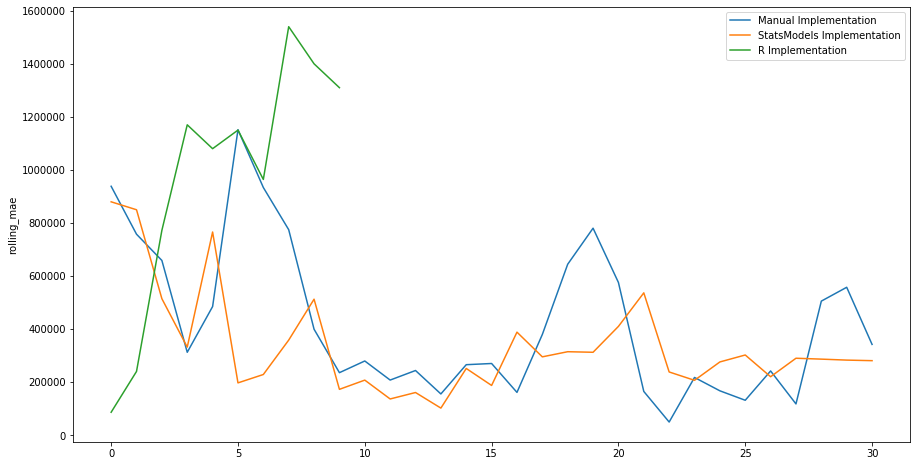

In [9]:
seasonal_period = 6
forecast_step_size = 3
manual_MAE_list = []
stats_MAE_list = []

split_point = int(round(seasonal_period * 2 + 1))
train, test = train_df.iloc[:split_point], train_df.iloc[split_point-1:split_point+forecast_step_size]

for i in range(seasonal_period * 2 + 1, len(train_df) - forecast_step_size):
    
    manual_exp_sm  = Exponential_Smoothing(train.price_doc, m=seasonal_period)
    
    results, levels, trends, seasons = manual_exp_sm.predict(start=0, end=len(train) + forecast_step_size + 1)  

    exp_model = ExponentialSmoothing(train.price_doc, trend='add', seasonal='add',  
                                 damped=False, seasonal_periods=seasonal_period).fit(optimized=True, remove_bias=False)

    pred = exp_model.predict(start=0, end=len(train) + forecast_step_size)

    manual_MAE_list.append(mean_absolute_error(results[i:], test.price_doc))
    stats_MAE_list.append(mean_absolute_error(pred[i:], test.price_doc))
    
    split_point = int(round(i + 1))
    train, test = train_df.iloc[:split_point], train_df.iloc[split_point-1:split_point+forecast_step_size]

r_MAE_list = pd.read_csv("./Rolling_MAE.csv")["rolling_mae"]

fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(x=range(0, len(manual_MAE_list)), y=manual_MAE_list, label='Manual Implementation', ax=ax)
sns.lineplot(x=range(0, len(stats_MAE_list)), y=stats_MAE_list, label='StatsModels Implementation', ax=ax)
sns.lineplot(x=range(0, len(r_MAE_list)), y=r_MAE_list, label='R Implementation', ax=ax)

ax1.legend(loc='best')
ax1.set_title("Rolling Forecast Origin")
ax1.set_ylabel("Mean Absolute Error")
ax1.set_xlabel("Forecasting Origin")
plt.show()
    

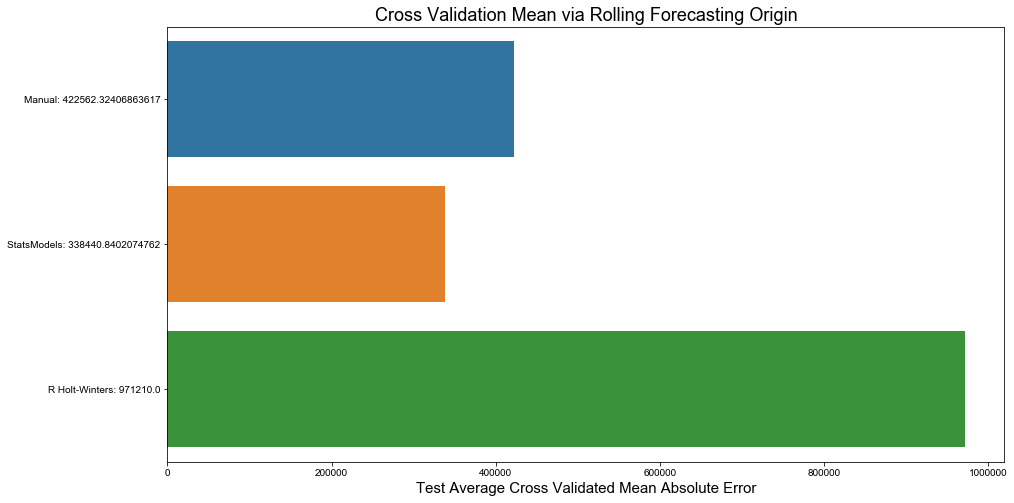

In [10]:
from statistics import mean

manual_cross_mean = mean(manual_MAE_list)
stats_cross_mean = mean(stats_MAE_list)
r_cross_mean = mean(r_MAE_list)

cross_means = [manual_cross_mean, stats_cross_mean, r_cross_mean]
implementation_names = [f"Manual: {manual_cross_mean}", f"StatsModels: {stats_cross_mean}", f"R Holt-Winters: {r_cross_mean}"]

cross_df = {"ImplementationNames": implementation_names, 
           "CrossMeans": cross_means}

fig, ax = plt.subplots(figsize=(15,8))

sns.barplot(x="CrossMeans", y="ImplementationNames", data=cross_df)
sns.set(font_scale=1.2)
ax.set_title("Cross Validation Mean via Rolling Forecasting Origin", fontsize=18)
ax.set_xlabel("Test Average Cross Validated Mean Absolute Error", fontsize=15)
plt.show()

#### Runtime Comparison

An important metric for evaluating an implementation of an algorithm is the time it takes to execute. This is because algorithms may be time sensitive, run at a certain frequency or in the case of data mining be scalable as data sets become increasingly large. For time series forecasting an example maybe making accurate stock market predictions in a timely manner so that you outcompete other traders. 
Our library solutions performed similary as R HoltWinters executed within 0.01 second ahead of StatsModels at 0.01326 seconds. To our surprise the manual implementation by far performed the best at 0.00579 seconds coupled with close results to StatsModels accuracy. This makes it the most reliable if it were to be applied in a time critical application.

In [11]:
# Determine the time efficiency of each of the Holt Winters implementations
durations = []
implementation_names = []
seasonal_period = 6

# Manual Implementation 
start_time = time.clock()

manual_exp_sm  = Exponential_Smoothing(train.price_doc, m=seasonal_period)
results, levels, trends, seasons = manual_exp_sm.predict(start=0, end=len(train)) 

end_time = time.clock()
diff_time = end_time - start_time
durations.append(diff_time)
implementation_names.append("Manual ({:.5f}s)".format(diff_time))

# StatsModels Implementation 
start_time = time.clock()
exp_model = ExponentialSmoothing(train.price_doc, trend='add', seasonal='add', 
                                 damped=False, seasonal_periods=seasonal_period).fit(optimized=False, 
                                                                                     smoothing_level=0.334679, 
                                                                                     smoothing_slope=0.0137731, 
                                                                                     smoothing_seasonal=0.7358153, 
                                                                                     remove_bias=False)
pred = exp_model.predict(start=0, end=len(train))

end_time = time.clock()
diff_time = end_time - start_time
durations.append(diff_time)
implementation_names.append("StatsModels ({:.5f}s)".format(diff_time))

# Read in the time from text file

# R (HoltWinters) Implementation 
diff_time = 0.01
durations.append(diff_time)
implementation_names.append("R (HoltWinters) ({:.5f}s)".format(diff_time))

# Create DataFrame of the experimental data
experimental_data = {"ImplementationNames": implementation_names,
                     "Durations": durations}

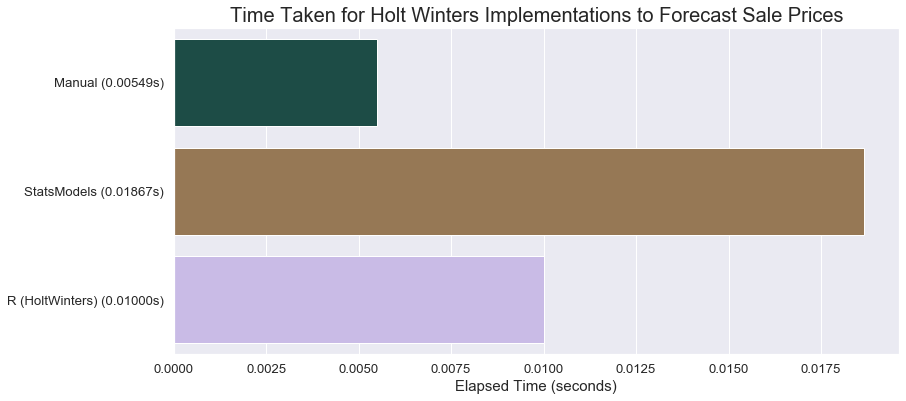

In [12]:
# Display a bar plot of the time efficiencies
sns.set(font_scale=1.2)
plt.figure(figsize=(13, 6))
ax = sns.barplot(x="Durations", y="ImplementationNames", data=experimental_data, palette="cubehelix")
ax.set_title("Time Taken for Holt Winters Implementations to Forecast Sale Prices", fontsize=20)
ax.set_xlabel("Elapsed Time (seconds)", fontsize=15)
plt.show()

#### Forecast Standard Deviation for Prediction Intervals


#### Analysing Residuals

Our fitted values are those which use observations from the time series to make predictions, combining our different characteristic componenents. Only values which don't involve observations are forecasts. After removing our fitted model by taking the difference with our observations we're left with what's called the resisiduals. This should be the remaining noise within the data that isn't a true reflection of the data generating mechanism. Attempting to model it will only lead to less generalised performance. For this to be the case, our residuals must be uncorrelated otherwise there's remaining information that should be used in our model and they must have a mean of zero otherwise our forecast is biased. Solving the bias problem is as simple adding the mean of the residuals to the forecasts.

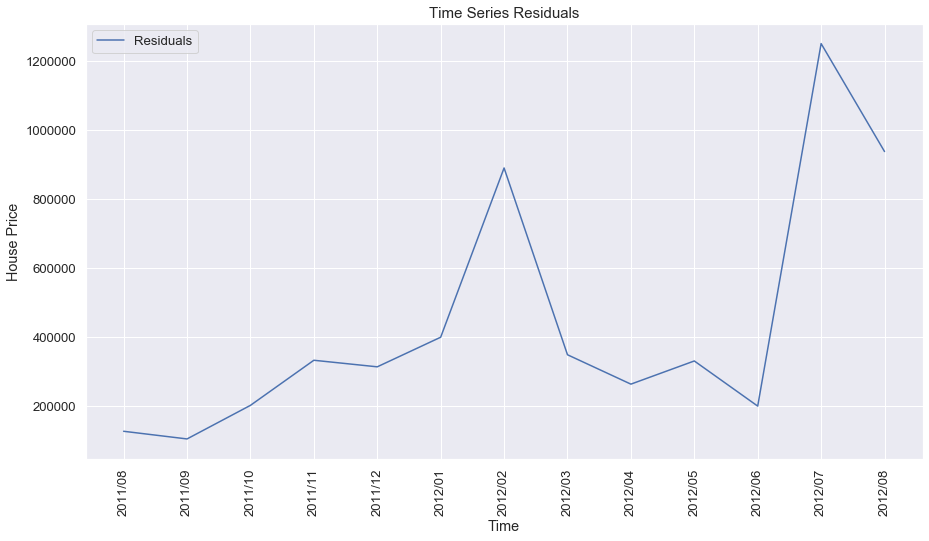

In [13]:
seasonal_period = 6
split_point = int(round(seasonal_period * 2 + 1))
train, test = train_df.iloc[:split_point], train_df.iloc[split_point-1:split_point+forecast_step_size]

manual_exp_sm  = Exponential_Smoothing(train.price_doc, m=seasonal_period)
results, levels, trends, seasons = manual_exp_sm.predict(start=0, end=len(train)) 

residuals = abs(train.price_doc - results)

fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x=train.yearMonth, y=residuals, label="Residuals")
sns.set(font_scale=1.2)
ax.set_title("Time Series Residuals", fontsize=15)
ax.set_ylabel("House Price")
ax.set_xlabel("Time")
plt.xticks(rotation=90)
plt.show()

In [14]:
print(f'Mean of Residuals: {residuals.mean()}')

Mean of Residuals: 438488.2045786922


We determined that the mean of our residual is 3692500.0, which compared to the scale of our data is still well above zero. Therefore our manual implementation has a high bias that we must take into consideration and asjust for whenever making forecasts. For this we should minus the mean of our residual. 

### Summary

In conclusion, we thoroughly explored the Russian housing markets sale price time series which spanned from August 2011 to June 2016. To begin with we found the optimal seasonal period so that it could be used with all of our implementations. Then we began our manual implementation finding comparable results to the StatsModels library solution. In a separate notebook we explored R's implementation of triple exponential smoothing with the Holt-Winter library. Each implementations' performance was then formally compared by calculating the mean square and mean absolute errors revealing that R's Holt Winter's is far inferrior. We also decomposed the manual implementations fitted values into their individual components which allowed us to uncover the housing markets price underlying characteristics. To more accurctly determine the performance of our implementations we implemented cross validation via a rolling forecasting origin algorithm. This saw contradiction between R's holt-winters and the other implementations where the error increased as the training set become larger. Next we wanted to determine the efficiency of each of the implementations whereby we calculated the runtime of each implementation. Impressively, our manual implementation saw a drastically lower runtime. Finally we computed the residuals of our manual implementation finding that it had a comparably high positive bias which was solvable by taking the difference of the residual mean.